<a href="https://colab.research.google.com/github/HyeongChanHam/Lung_Cancer_detection/blob/master/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm
from skimage.transform import resize


from keras.callbacks import TensorBoard

from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
tf.test.gpu_device_name()

from google.colab import drive
drive.mount('/content/gdrive')

PATH = "gdrive/My Drive/lung_cancer/"
img_path = PATH+'images/image/'
label_path = PATH+'masks/mask/'

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
img_ids = next(os.walk(img_path))[2]
label_ids = next(os.walk(label_path))[2]
img_ids.sort()
label_ids.sort()

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [3]:
print(len(img_ids))
print(len(label_ids))

6243
6243


In [0]:
# train_val split directory
# !mkdir -p gdrive/'My Drive'/lung_cancer/split/train
# !mkdir -p gdrive/'My Drive'/lung_cancer/split/val
# import shutil
# for i in img_ids[:int(len(img_ids)*0.8)]:
#     print(img_path + 'image/'+i)
#     shutil.copy(img_path+'image/'+i, "gdrive/My Drive/lung_cancer/split/train/image")

# for i in img_ids[int(len(img_ids)*0.8):]:
#     print(img_path + 'image/'+i)
#     shutil.copy(img_path+'image/'+i, "gdrive/My Drive/lung_cancer/split/val/image")

# for i in label_ids[:int(len(label_ids)*0.8)]:
#     print(label_path + 'mask/'+i)
#     shutil.copy(label_path+'mask/'+i, "gdrive/My Drive/lung_cancer/split/train/mask")
    
# for i in label_ids[int(len(label_ids)*0.8):]:
#     print(label_path + 'mask/'+i)
#     shutil.copy(label_path+'mask/'+i, "gdrive/My Drive/lung_cancer/split/train/mask")

In [4]:
# load all data to memory
X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    path = img_path +id_
    img = np.expand_dims(imread(path),axis=2)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(label_ids), total=len(label_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    path = label_path+id_
    label = np.expand_dims(imread(path), axis=2)
    mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask

100%|██████████| 6243/6243 [1:04:42<00:00,  1.61it/s]


In [0]:
# shuffle images
ind_list = [i for i in range(len(X_train))]
random.shuffle(ind_list)

X_train_norm = (X_train - X_train.mean()) / X_train.std()

X_train_shuffled = X_train_norm[ind_list]
Y_train_shuffled = Y_train[ind_list]

_X_train = X_train_shuffled[:int(X_train.shape[0]*0.8)]
_Y_train = Y_train_shuffled[:int(Y_train.shape[0]*0.8)]

_X_val = X_train_shuffled[int(X_train.shape[0]*0.8):]
_Y_val = Y_train_shuffled[int(Y_train.shape[0]*0.8):]

In [0]:
# Define IoU metric
from keras import backend as K
def iou(y_true, y_pred):
    intersection = (y_true[:,:,0]*y_pred[:,:,0]).sum()
    union =y_true[:,:,0].sum() + y_pred[:,:,0].sum() - intersection
    return intersection/union

In [8]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
adam = Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam, loss='binary_crossentropy')

# model.summary()
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2020-4.h5', verbose=1, save_best_only=True)

with tf.device('/device:GPU:0'):
    results = model.fit(_X_train, _Y_train, validation_split=0.1, batch_size=4, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 4494 samples, validate on 500 samples
Epoch 1/100
4494/4494 [==============================] - 35s 8ms/step - loss: 0.0277 - val_loss: 0.0079

Epoch 00001: val_loss improved from inf to 0.00793, saving model to model-dsbowl2020-4.h5
Epoch 2/100
4494/4494 [==============================] - 27s 6ms/step - loss: 0.0069 - val_loss: 0.0066

Epoch 00002: val_loss improved from 0.00793 to 0.00656, saving model to model-dsbowl2020-4.h5
Epoch 3/100
4494/4494 [==============================] - 27s 6ms/step - loss: 0.0057 - val_loss: 0.0060

Epoch 00003: val_loss improved from 0.00656 to 0.00600, saving model to model-dsbowl2020-4.h5
Epoch 4/100
4494/4494 [==============================] - 27s 6ms/step - loss: 0.0049 - val_loss: 0.0044

Epoch 00004: val_loss improved from 0.00600 to 0.00439, saving model to model-dsbowl2020-4.h5
Epoch 5/100
4494/4494 [==============================] - 27s 6ms/step - loss: 0.0043 - val_loss: 0.0040

Epoch 00005: val_loss improved from 0.00439 to 0.00401, 

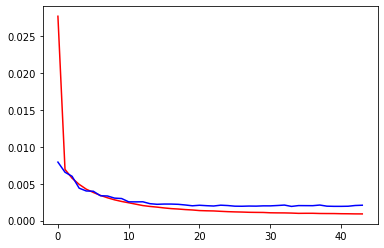

In [9]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epoch = len(loss)
plt.plot(loss, 'r')
plt.plot(val_loss,'b')
plt.show()

1249/1249 [==============================] - 2s 1ms/step


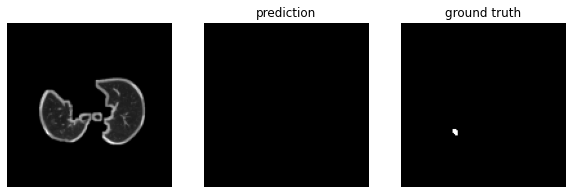

iou :  0.0


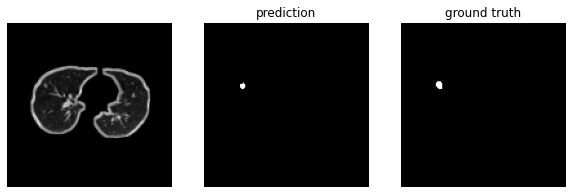

iou :  0.6


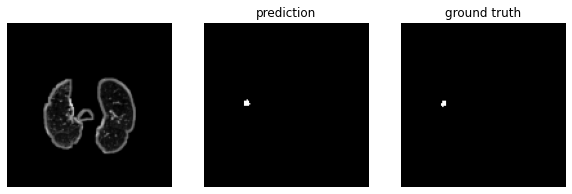

iou :  0.7368421052631579


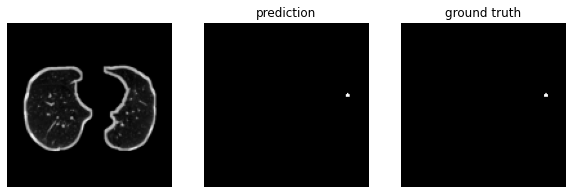

iou :  0.4


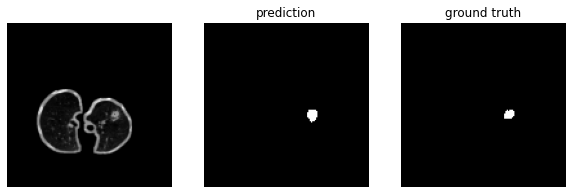

iou :  0.7419354838709677


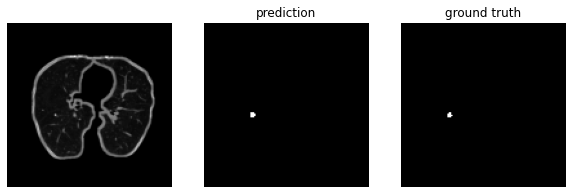

iou :  0.8571428571428571


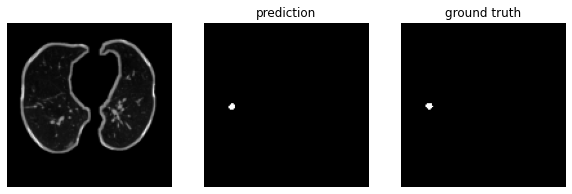

iou :  0.7391304347826086


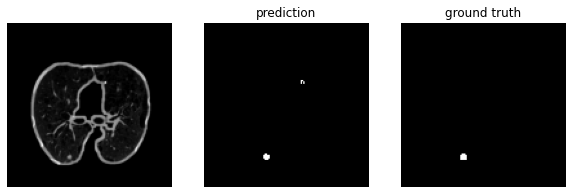

iou :  0.6896551724137931


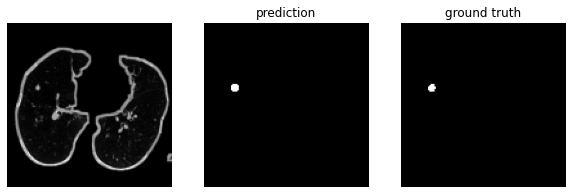

iou :  0.875


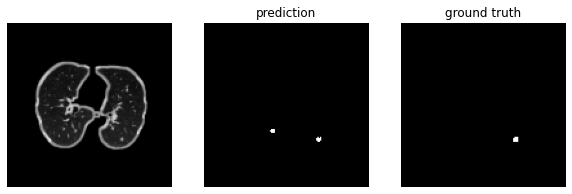

iou :  0.48
[0.27777778 0.9        0.88571429 ... 0.82894737 0.97297297 0.1875    ]
0.6533487921025795
0.8975180144115292


In [10]:
# Predict on train, val and test
# model = load_model('model-dsbowl2020-4.h5')
# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(_X_val, verbose=1)

# Threshold predictions
# preds_train_t = (preds_train > 0.4).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

iou_vec = np.array([])
for i in range(10):
    ix = random.randint(0, len(_X_val))
    fig, ax = plt.subplots(1,3,figsize=(10,6))
    ax[0].imshow(_X_val[ix][:,:,0],cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(preds_val_t[ix][:,:,0]),cmap='gray')
    ax[1].title.set_text("prediction")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(_Y_val[ix][:,:,0]),cmap='gray')
    ax[2].title.set_text("ground truth")
    ax[2].axis('off')
    plt.show()
    print("iou : ",iou(preds_val_t[ix].astype(np.bool),_Y_val[ix]))

for i in range(len(preds_val_t)):
    iou_vec = np.append(iou_vec, iou(preds_val_t[i].astype(np.bool),_Y_val[i]))
print(iou_vec)
print(iou_vec.mean())
print(np.where(iou_vec>0,1,0).mean())